# White Box Model Exploration

The idea of this section is to explore how good the WB model is, and to decide whether it is possible to make it more accurate

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import json
from config import DATA_DIR, TFO_PARAMETERS_FILE

alldf = pd.read_csv('data/final_merged_data_with_wb_pred.csv')

exclude_ids = [76075, 76632]

alldf = alldf[~alldf['equipmentId'].isin(exclude_ids)]

alldf

,Unnamed: 0.1,Unnamed: 0,equipmentId,nominalLoad,locationId,coolingType,manufactureYear,commissioningDate,enclosure,heatRunTest_noLoadLosses,...,heatRunTest_h,heatRunTest_gradient,dateTime,load,hotspotTemperature,temperature,windSpeed,relativeHumidityPercentage,city,wb_pred
0,0,0,50033827,40.0,26,ONAF1,2008,2010-03-17T00:00:00,1 wall,16.37,...,1.13,11.8,2023-04-30 23:00:00,10130.00,40.50,12.26,2.05,70.96,Wilsele,NaN
1,1,4,50033827,40.0,26,ONAF1,2008,2010-03-17T00:00:00,1 wall,16.37,...,1.13,11.8,2023-05-01 00:00:00,9160.97,38.61,11.73,1.60,74.35,Wilsele,25.356879
2,2,8,50033827,40.0,26,ONAF1,2008,2010-03-17T00:00:00,1 wall,16.37,...,1.13,11.8,2023-05-01 01:00:00,12049.23,38.77,11.35,1.39,77.63,Wilsele,28.064633
3,3,12,50033827,40.0,26,ONAF1,2008,2010-03-17T00:00:00,1 wall,16.37,...,1.13,11.8,2023-05-01 02:00:00,11077.78,38.67,10.80,1.13,80.86,Wilsele,26.411574
4,4,16,50033827,40.0,26,ONAF1,2008,2010-03-17T00:00:00,1 wall,16.37,...,1.13,11.8,2023-05-01 03:00:00,11093.11,37.92,10.62,1.00,82.36,Wilsele,26.248490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249283,249283,997132,50249457,25.0,2,ONAF1,2011,2016-04-15T00:00:00,4 walls,9.50,...,1.10,14.4,2024-12-31 18:00:00,15281.92,47.47,3.87,7.27,94.12,Anderlecht,41.547430
249284,249284,997136,50249457,25.0,2,ONAF1,2011,2016-04-15T00:00:00,4 walls,9.50,...,1.10,14.4,2024-12-31 19:00:00,14497.30,48.05,4.15,7.33,93.61,Anderlecht,39.675514
249285,249285,997140,50249457,25.0,2,ONAF1,2011,2016-04-15T00:00:00,4 walls,9.50,...,1.10,14.4,2024-12-31 20:00:00,13493.01,47.65,4.28,7.48,92.85,Anderlecht,37.123920
249286,249286,997144,50249457,25.0,2,ONAF1,2011,2016-04-15T00:00:00,4 walls,9.50,...,1.10,14.4,2024-12-31 21:00:00,12719.02,46.36,4.61,8.14,93.20,Anderlecht,35.446373


In [22]:
# Count of rows with hotspotTemperature 0
(alldf['hotspotTemperature'] == 0).sum()

np.int64(0)

In [25]:
def eval_wb(df, y_true='hotspotTemperature', y_pred='wb_pred', load_col='load', nominal_load_col='nominalLoad'):
    d = df[[y_true, y_pred, load_col, nominal_load_col]].dropna().copy()
    err = d[y_pred] - d[y_true]
    mae  = np.mean(np.abs(err))
    rmse = np.sqrt(np.mean(err**2))
    mbe  = np.mean(err)
    # Normalize by IQR of true temps (robust scale)
    iqr = d[y_true].quantile(0.75) - d[y_true].quantile(0.25)
    nrmse_pct = 100 * rmse / (iqr if iqr > 0 else (d[y_true].max()-d[y_true].min()))
    r2 = 1 - np.sum(err**2) / np.sum((d[y_true] - d[y_true].mean())**2)

    # Percentile and max errors (good for risk)
    p95_abs = np.percentile(np.abs(err), 95)
    max_abs = np.max(np.abs(err))

    # Binned metrics by K
    bins = [0, 0.5, 0.9, 1.1, np.inf]
    labels = ["<0.5", "0.5–0.9", "0.9–1.1", ">1.1"]
    d['K_bin'] = pd.cut(d[load_col]/(d[nominal_load_col]*1000), bins=bins, labels=labels, include_lowest=True)
    byK = d.groupby('K_bin').apply(
        lambda g: pd.Series({
            'n': len(g),
            'MAE': np.mean(np.abs(g[y_pred]-g[y_true])),
            'RMSE': np.sqrt(np.mean((g[y_pred]-g[y_true])**2)),
            'Bias': np.mean(g[y_pred]-g[y_true])
        })
    )

    return {
        'MAE': mae, 'RMSE': rmse, 'Bias': mbe,
        'NRMSE%_IQR': nrmse_pct, 'R2': r2,
        'P95_abs_err': p95_abs, 'Max_abs_err': max_abs,
        'by_K_bin': byK
    }

# Example usage:
# results = eval_wb(df)  # df must have temp_meas, wb_pred, K
# print(results)


In [23]:
eval_results = eval_wb(alldf)
eval_results

C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\4117572504.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\4117572504.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(


{'MAE': np.float64(7.545723646063696),
 'RMSE': np.float64(9.101360473733653),
 'Bias': np.float64(-7.1579483211514985),
 'NRMSE%_IQR': np.float64(60.91941414815028),
 'R2': np.float64(0.43103795374704923),
 'P95_abs_err': np.float64(16.950794539915538),
 'Max_abs_err': np.float64(102.62035619691665),
 'by_K_bin':                 n       MAE       RMSE      Bias
 K_bin                                           
 <0.5     183404.0  7.310829   8.842928 -6.954073
 0.5–0.9   23173.0  9.411280  11.031613 -8.615603
 0.9–1.1     407.0  8.490335   9.412346 -8.208187
 >1.1          0.0       NaN        NaN       NaN}

## Problems with the data

- Sometimes ambient T is missing
- Sometimes hotspot T goes to negative values or shoots up (e.g. 5030256)
![image](figures/notebooks/hotspot_t_shoots_up_or_down.png)
- Sometimes, when there is no load, the transformer has a voltage and sometimes it doesn't. In this picture it's clear when the transformer is energized
![image](figures/notebooks/energized_vs_non_energized_without_load.png)

# Possible Improvements

- $R = \frac{P_{cu}}{(1-s) P_{no\_loss}}$, with $s \approx 0.1$

- $ K = \frac{S_{load}}{S_{rated}} = \frac{P}{PF \dot S_{rated}} $ where PF is the Power Factor as $ PF = cos(\phi) $ and $\phi$ is the phase shift between current and voltage. $ PF \approx 0.9$

- When load is 0, $ T_{wb\_pred} \neq T_{amb} $

In [ ]:
def white_box_model(theta_a, delta_top_oil, delta_hotspot, x_param, y_param, R=0.1, K=0.05):
    #theta_a = x[:, 3]  # ambient temperature
    #delta_top_oil = x[:, 4]  # delta top oil
    #delta_hotspot = x[:, -2]  # heat run test y (assumption)
    #x_param = x[:, -3]  # heat run test x (assumption)
    #y_param = x[:, -1]  # heat run test gradient (assumption)

    white_box_pred = ((1 + R * K ** 2) / (1 + R)) ** x_param * \
                     delta_top_oil + K ** y_param * (delta_hotspot - delta_top_oil) + theta_a
    return white_box_pred

def get_wb_prediction_naive(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, load, nominal_load, copper_loss, no_load_loss):
    R = 0.1
    K = load / (nominal_load * 1000)  # Convert kW to W
    wb_pred = white_box_model(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, R, K)
    return wb_pred

def get_wb_prediction_pro(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, load, nominal_load, copper_loss, no_load_loss, s, pf):
    R = copper_loss / ((1 - s) * no_load_loss)  # s is approx 0.1
    K = load / (pf * nominal_load * 1000)  # Convert MW to kW, pf is power factor approx 0.9
    wb_pred = white_box_model(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, R, K)
    return wb_pred

def wb_preds_for_df(df, s = None, pf = None):
    df = df.copy()
    df['wb_pred'] = get_wb_prediction_pro(
        df['temperature'],
        df['heatRunTest_deltaTopOil'],
        df['heatRunTest_deltaHotspot'],
        df['heatRunTest_x'],
        df['heatRunTest_y'],
        df['load'],
        df['nominalLoad'],
        df['heatRunTest_copperLosses'],
        df['heatRunTest_noLoadLosses'],
        s = 0 if s is None else s,
        pf = 1 if pf is None else pf
    )
    return df

In [67]:
# Here it uses the gradient column instead of delta_hotspot - delta_top_oil

def white_box_model(theta_a, delta_top_oil, gradient, x_param, y_param, R=0.1, K=0.05):
    #theta_a = x[:, 3]  # ambient temperature
    #delta_top_oil = x[:, 4]  # delta top oil
    #delta_hotspot = x[:, -2]  # heat run test y (assumption)
    #x_param = x[:, -3]  # heat run test x (assumption)
    #y_param = x[:, -1]  # heat run test gradient (assumption)

    white_box_pred = ((1 + R * K ** 2) / (1 + R)) ** x_param * \
                     delta_top_oil + K ** y_param * gradient + theta_a
    return white_box_pred

def get_wb_prediction_naive(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, load, nominal_load, copper_loss, no_load_loss):
    R = 0.1
    K = load / (nominal_load * 1000)  # Convert kW to W
    wb_pred = white_box_model(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, R, K)
    return wb_pred

def get_wb_prediction_pro(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, load, nominal_load, copper_loss, no_load_loss, s, pf):
    R = copper_loss / ((1 - s) * no_load_loss)  # s is approx 0.1
    K = load / (pf * nominal_load * 1000)  # Convert MW to kW, pf is power factor approx 0.9
    wb_pred = white_box_model(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, R, K)
    return wb_pred

def wb_preds_for_df(df, s = None, pf = None):
    df = df.copy()
    df['wb_pred'] = get_wb_prediction_pro(
        df['temperature'],
        df['heatRunTest_deltaTopOil'],
        df['heatRunTest_gradient'],
        df['heatRunTest_x'],
        df['heatRunTest_y'],
        df['load'],
        df['nominalLoad'],
        df['heatRunTest_copperLosses'],
        df['heatRunTest_noLoadLosses'],
        s = 0 if s is None else s,
        pf = 1 if pf is None else pf
    )
    return df

In [68]:
df = wb_preds_for_df(alldf)
results = eval_wb(df)
results

C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(


{'MAE': np.float64(7.898856894776845),
 'RMSE': np.float64(9.460494431035835),
 'Bias': np.float64(-7.567956896965914),
 'NRMSE%_IQR': np.float64(61.47169870718541),
 'R2': np.float64(0.40492325355711667),
 'P95_abs_err': np.float64(17.477422137299286),
 'Max_abs_err': np.float64(101.77319554694921),
 'by_K_bin':                 n        MAE       RMSE      Bias
 K_bin                                            
 <0.5     183419.0   7.606125   9.119759 -7.296244
 0.5–0.9   23173.0  10.179606  11.794978 -9.679414
 0.9–1.1     407.0   9.964445  10.835804 -9.800322
 >1.1          0.0        NaN        NaN       NaN}

In [70]:
# Here i am including h also

def white_box_model(theta_a, delta_top_oil, gradient, x_param, y_param, h, R, K):
    #theta_a = x[:, 3]  # ambient temperature
    #delta_top_oil = x[:, 4]  # delta top oil
    #delta_hotspot = x[:, -2]  # heat run test y (assumption)
    #x_param = x[:, -3]  # heat run test x (assumption)
    #y_param = x[:, -1]  # heat run test gradient (assumption)

    white_box_pred = ((1 + R * K ** 2) / (1 + R)) ** x_param * \
                     delta_top_oil + h * K ** y_param * gradient + theta_a
    return white_box_pred

def get_wb_prediction_naive(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, heat_run_test_h, load, nominal_load, copper_loss, no_load_loss):
    R = 0.1
    K = load / (nominal_load * 1000)  # Convert kW to W
    wb_pred = white_box_model(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, heat_run_test_h, R, K)
    return wb_pred

def get_wb_prediction_pro(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, heat_run_test_h, load, nominal_load, copper_loss, no_load_loss, s, pf):
    R = copper_loss / ((1 - s) * no_load_loss)  # s is approx 0.1
    K = load / (pf * nominal_load * 1000)  # Convert MW to kW, pf is power factor approx 0.9
    wb_pred = white_box_model(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, heat_run_test_h, R, K)
    return wb_pred

def wb_preds_for_df(df, s = None, pf = None):
    df = df.copy()
    df['wb_pred'] = get_wb_prediction_pro(
        df['temperature'],
        df['heatRunTest_deltaTopOil'],
        df['heatRunTest_gradient'],
        df['heatRunTest_x'],
        df['heatRunTest_y'],
        df['heatRunTest_h'],
        df['load'],
        df['nominalLoad'],
        df['heatRunTest_copperLosses'],
        df['heatRunTest_noLoadLosses'],
        s = 0 if s is None else s,
        pf = 1 if pf is None else pf
    )
    return df

In [71]:
df = wb_preds_for_df(alldf)
results = eval_wb(df)
results

C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(


{'MAE': np.float64(7.544876263386686),
 'RMSE': np.float64(9.111367094685729),
 'Bias': np.float64(-7.139613037629815),
 'NRMSE%_IQR': np.float64(59.20316500770454),
 'R2': np.float64(0.44803390672794474),
 'P95_abs_err': np.float64(16.97595508225528),
 'Max_abs_err': np.float64(102.64456078691572),
 'by_K_bin':                 n       MAE       RMSE      Bias
 K_bin                                           
 <0.5     183419.0  7.308531   8.840195 -6.952039
 0.5–0.9   23173.0  9.399365  11.020755 -8.605957
 0.9–1.1     407.0  8.468951   9.391011 -8.183873
 >1.1          0.0       NaN        NaN       NaN}

In [72]:
# Lastly I am using h but also (delta_hotspot - delta_top_oil)

def white_box_model(theta_a, delta_top_oil, delta_hotspot, x_param, y_param, h, R, K):
    #theta_a = x[:, 3]  # ambient temperature
    #delta_top_oil = x[:, 4]  # delta top oil
    #delta_hotspot = x[:, -2]  # heat run test y (assumption)
    #x_param = x[:, -3]  # heat run test x (assumption)
    #y_param = x[:, -1]  # heat run test gradient (assumption)

    white_box_pred = ((1 + R * K ** 2) / (1 + R)) ** x_param * \
                     delta_top_oil + h * K ** y_param * (delta_hotspot - delta_top_oil) + theta_a
    return white_box_pred

def get_wb_prediction_naive(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, heat_run_test_h, load, nominal_load, copper_loss, no_load_loss):
    R = 0.1
    K = load / (nominal_load * 1000)  # Convert kW to W
    wb_pred = white_box_model(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, heat_run_test_h, R, K)
    return wb_pred

def get_wb_prediction_pro(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, heat_run_test_h, load, nominal_load, copper_loss, no_load_loss, s, pf):
    R = copper_loss / ((1 - s) * no_load_loss)  # s is approx 0.1
    K = load / (pf * nominal_load * 1000)  # Convert MW to kW, pf is power factor approx 0.9
    wb_pred = white_box_model(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, heat_run_test_h, R, K)
    return wb_pred

def wb_preds_for_df(df, s = None, pf = None):
    df = df.copy()
    df['wb_pred'] = get_wb_prediction_pro(
        df['temperature'],
        df['heatRunTest_deltaTopOil'],
        df['heatRunTest_deltaHotspot'],
        df['heatRunTest_x'],
        df['heatRunTest_y'],
        df['heatRunTest_h'],
        df['load'],
        df['nominalLoad'],
        df['heatRunTest_copperLosses'],
        df['heatRunTest_noLoadLosses'],
        s = 0 if s is None else s,
        pf = 1 if pf is None else pf
    )
    return df

In [73]:
df = wb_preds_for_df(alldf)
results = eval_wb(df)
results

C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(


{'MAE': np.float64(7.156129355842767),
 'RMSE': np.float64(8.737205320892862),
 'Bias': np.float64(-6.62184851010227),
 'NRMSE%_IQR': np.float64(56.77196439826421),
 'R2': np.float64(0.49243648744657387),
 'P95_abs_err': np.float64(16.47001790777963),
 'Max_abs_err': np.float64(103.5764375018799),
 'by_K_bin':                 n       MAE       RMSE      Bias
 K_bin                                           
 <0.5     183419.0  6.968196   8.527692 -6.529281
 0.5–0.9   23173.0  8.649082  10.257658 -7.358758
 0.9–1.1     407.0  6.847515   7.881779 -6.381571
 >1.1          0.0       NaN        NaN       NaN}

C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-0.6, pf=1 -> MAE=5.66, RMSE=7.32, Bias=-4.50, R2=0.644
s=-0.6, pf=0.95 -> MAE=5.24, RMSE=6.84, Bias=-3.75, R2=0.689


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-0.6, pf=0.9 -> MAE=4.91, RMSE=6.44, Bias=-2.89, R2=0.724
s=-0.6, pf=0.85 -> MAE=4.75, RMSE=6.24, Bias=-1.90, R2=0.741


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-0.6, pf=0.8 -> MAE=4.82, RMSE=6.36, Bias=-0.74, R2=0.731
s=-0.6, pf=0.75 -> MAE=5.19, RMSE=6.97, Bias=0.62, R2=0.677


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-0.6, pf=0.7 -> MAE=5.91, RMSE=8.18, Bias=2.23, R2=0.555
s=-0.8, pf=1 -> MAE=5.32, RMSE=6.97, Bias=-3.86, R2=0.677


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-0.8, pf=0.95 -> MAE=4.96, RMSE=6.53, Bias=-3.13, R2=0.717
s=-0.8, pf=0.9 -> MAE=4.69, RMSE=6.19, Bias=-2.28, R2=0.745


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-0.8, pf=0.85 -> MAE=4.60, RMSE=6.06, Bias=-1.30, R2=0.756
s=-0.8, pf=0.8 -> MAE=4.74, RMSE=6.27, Bias=-0.17, R2=0.739


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

s=-0.8, pf=0.75 -> MAE=5.17, RMSE=6.96, Bias=1.17, R2=0.678
s=-0.8, pf=0.7 -> MAE=5.95, RMSE=8.22, Bias=2.76, R2=0.550
s=-1, pf=1 -> MAE=5.05, RMSE=6.68, Bias=-3.26, R2=0.703


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1, pf=0.95 -> MAE=4.75, RMSE=6.28, Bias=-2.53, R2=0.738
s=-1, pf=0.9 -> MAE=4.54, RMSE=6.00, Bias=-1.70, R2=0.760
s=-1, pf=0.85 -> MAE=4.50, RMSE=5.94, Bias=-0.74, R2=0.765


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1, pf=0.8 -> MAE=4.71, RMSE=6.23, Bias=0.38, R2=0.742
s=-1, pf=0.75 -> MAE=5.20, RMSE=6.99, Bias=1.70, R2=0.675
s=-1, pf=0.7 -> MAE=6.03, RMSE=8.31, Bias=3.26, R2=0.541


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.2, pf=1 -> MAE=4.85, RMSE=6.44, Bias=-2.67, R2=0.724
s=-1.2, pf=0.95 -> MAE=4.59, RMSE=6.09, Bias=-1.96, R2=0.753


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.2, pf=0.9 -> MAE=4.44, RMSE=5.87, Bias=-1.14, R2=0.771
s=-1.2, pf=0.85 -> MAE=4.46, RMSE=5.88, Bias=-0.20, R2=0.770


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

s=-1.2, pf=0.8 -> MAE=4.72, RMSE=6.24, Bias=0.91, R2=0.741
s=-1.2, pf=0.75 -> MAE=5.27, RMSE=7.06, Bias=2.20, R2=0.668
s=-1.2, pf=0.7 -> MAE=6.14, RMSE=8.42, Bias=3.75, R2=0.529


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.4, pf=1 -> MAE=4.71, RMSE=6.26, Bias=-2.12, R2=0.740
s=-1.4, pf=0.95 -> MAE=4.50, RMSE=5.96, Bias=-1.41, R2=0.764


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

s=-1.4, pf=0.9 -> MAE=4.40, RMSE=5.80, Bias=-0.61, R2=0.776
s=-1.4, pf=0.85 -> MAE=4.47, RMSE=5.88, Bias=0.32, R2=0.770


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

s=-1.4, pf=0.8 -> MAE=4.78, RMSE=6.30, Bias=1.41, R2=0.736
s=-1.4, pf=0.75 -> MAE=5.37, RMSE=7.17, Bias=2.69, R2=0.658
s=-1.4, pf=0.7 -> MAE=6.29, RMSE=8.55, Bias=4.21, R2=0.514


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.6, pf=1 -> MAE=4.62, RMSE=6.13, Bias=-1.58, R2=0.751
s=-1.6, pf=0.95 -> MAE=4.45, RMSE=5.88, Bias=-0.89, R2=0.770
s=-1.6, pf=0.9 -> MAE=4.40, RMSE=5.78, Bias=-0.10, R2=0.778


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.6, pf=0.85 -> MAE=4.52, RMSE=5.92, Bias=0.82, R2=0.767
s=-1.6, pf=0.8 -> MAE=4.87, RMSE=6.40, Bias=1.90, R2=0.728
s=-1.6, pf=0.75 -> MAE=5.50, RMSE=7.31, Bias=3.16, R2=0.645


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.6, pf=0.7 -> MAE=6.46, RMSE=8.71, Bias=4.66, R2=0.496
s=-1.8, pf=1 -> MAE=4.57, RMSE=6.04, Bias=-1.07, R2=0.757


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

s=-1.8, pf=0.95 -> MAE=4.45, RMSE=5.84, Bias=-0.39, R2=0.773
s=-1.8, pf=0.9 -> MAE=4.43, RMSE=5.80, Bias=0.40, R2=0.776
s=-1.8, pf=0.85 -> MAE=4.60, RMSE=6.00, Bias=1.30, R2=0.761


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.8, pf=0.8 -> MAE=5.00, RMSE=6.53, Bias=2.36, R2=0.717
s=-1.8, pf=0.75 -> MAE=5.66, RMSE=7.47, Bias=3.61, R2=0.629


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

s=-1.8, pf=0.7 -> MAE=6.65, RMSE=8.88, Bias=5.09, R2=0.476
s=-2, pf=1 -> MAE=4.57, RMSE=6.00, Bias=-0.58, R2=0.761
s=-2, pf=0.95 -> MAE=4.48, RMSE=5.85, Bias=0.10, R2=0.772


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-2, pf=0.9 -> MAE=4.51, RMSE=5.86, Bias=0.87, R2=0.771
s=-2, pf=0.85 -> MAE=4.71, RMSE=6.11, Bias=1.77, R2=0.752
s=-2, pf=0.8 -> MAE=5.15, RMSE=6.68, Bias=2.81, R2=0.703


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-2, pf=0.75 -> MAE=5.85, RMSE=7.64, Bias=4.04, R2=0.612
s=-2, pf=0.7 -> MAE=6.86, RMSE=9.06, Bias=5.51, R2=0.454

Saved grid results to wb_full_eval_grid.csv


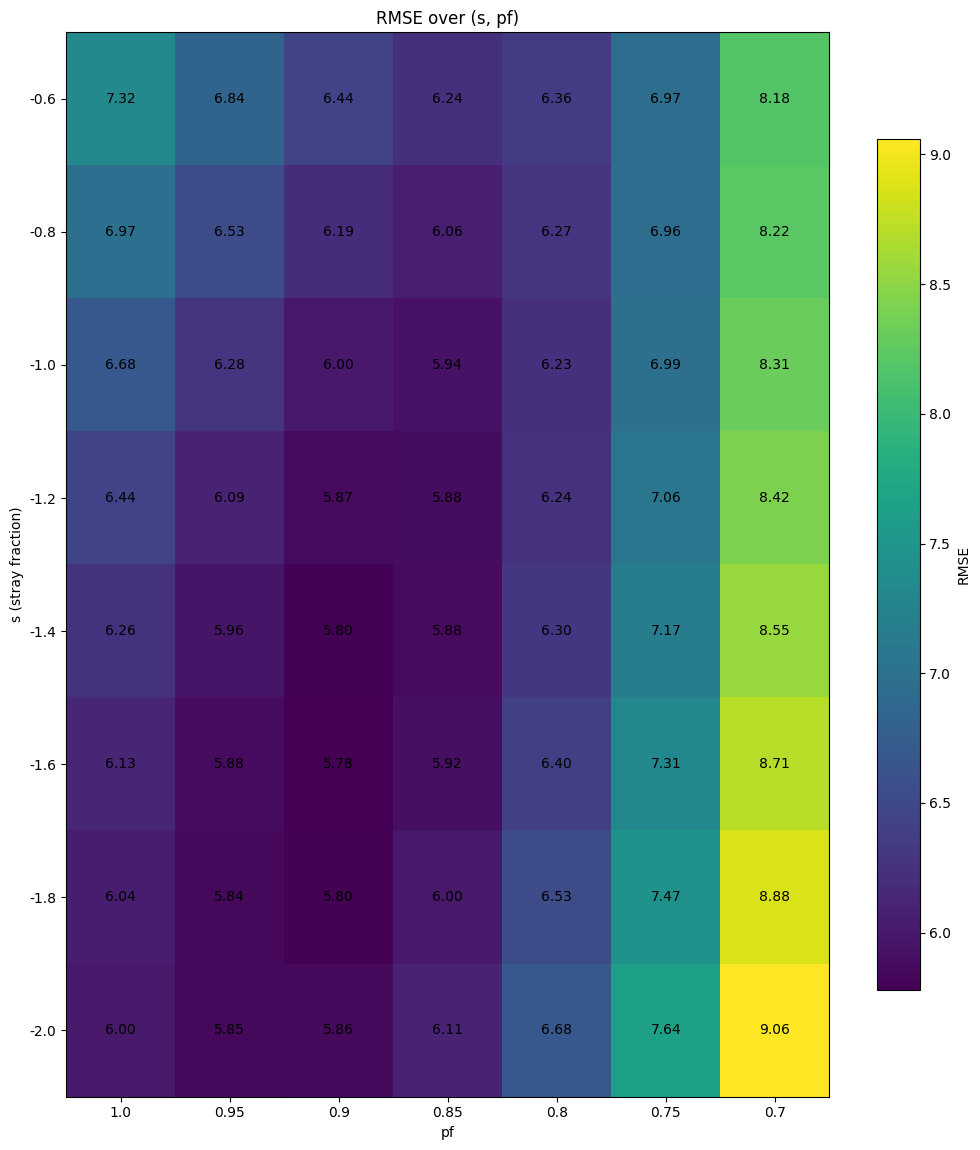

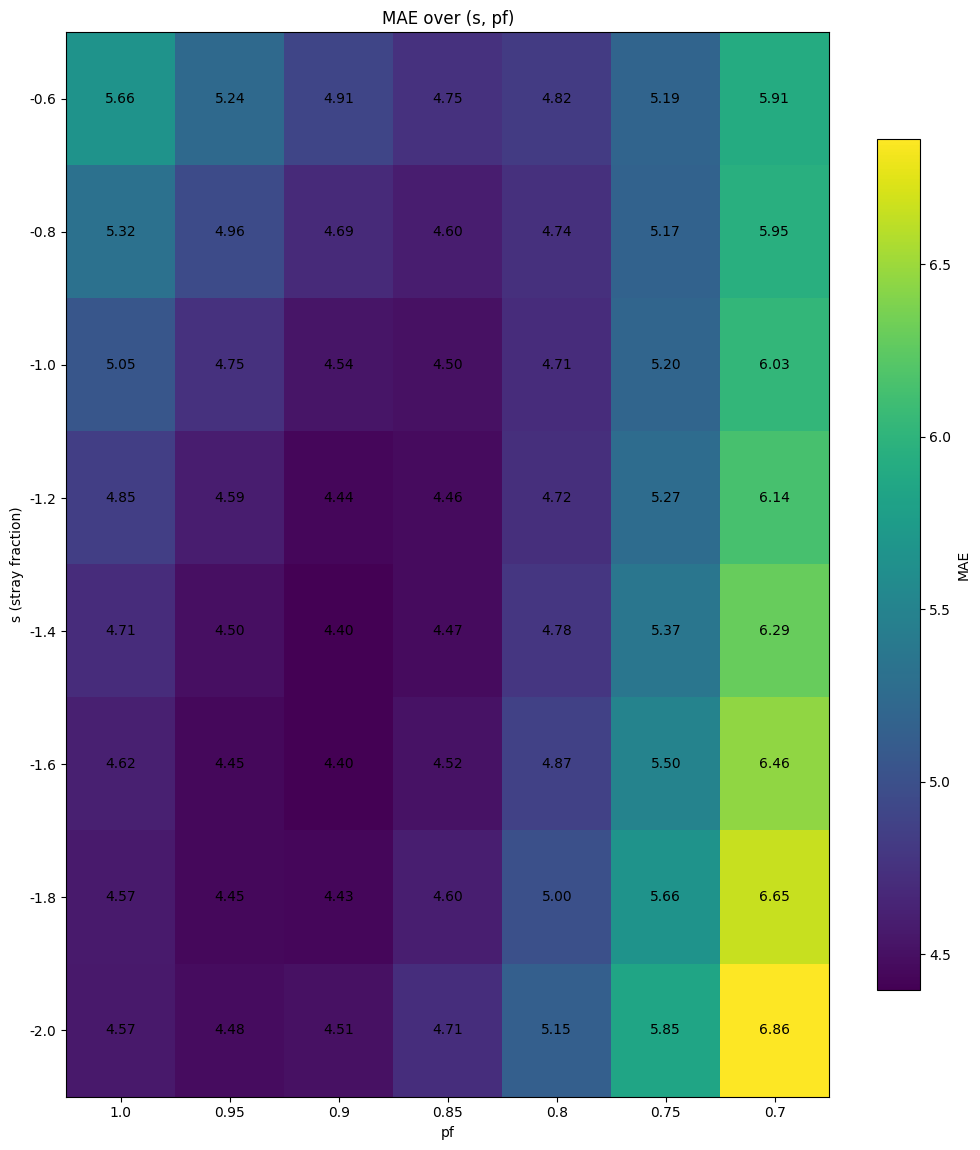

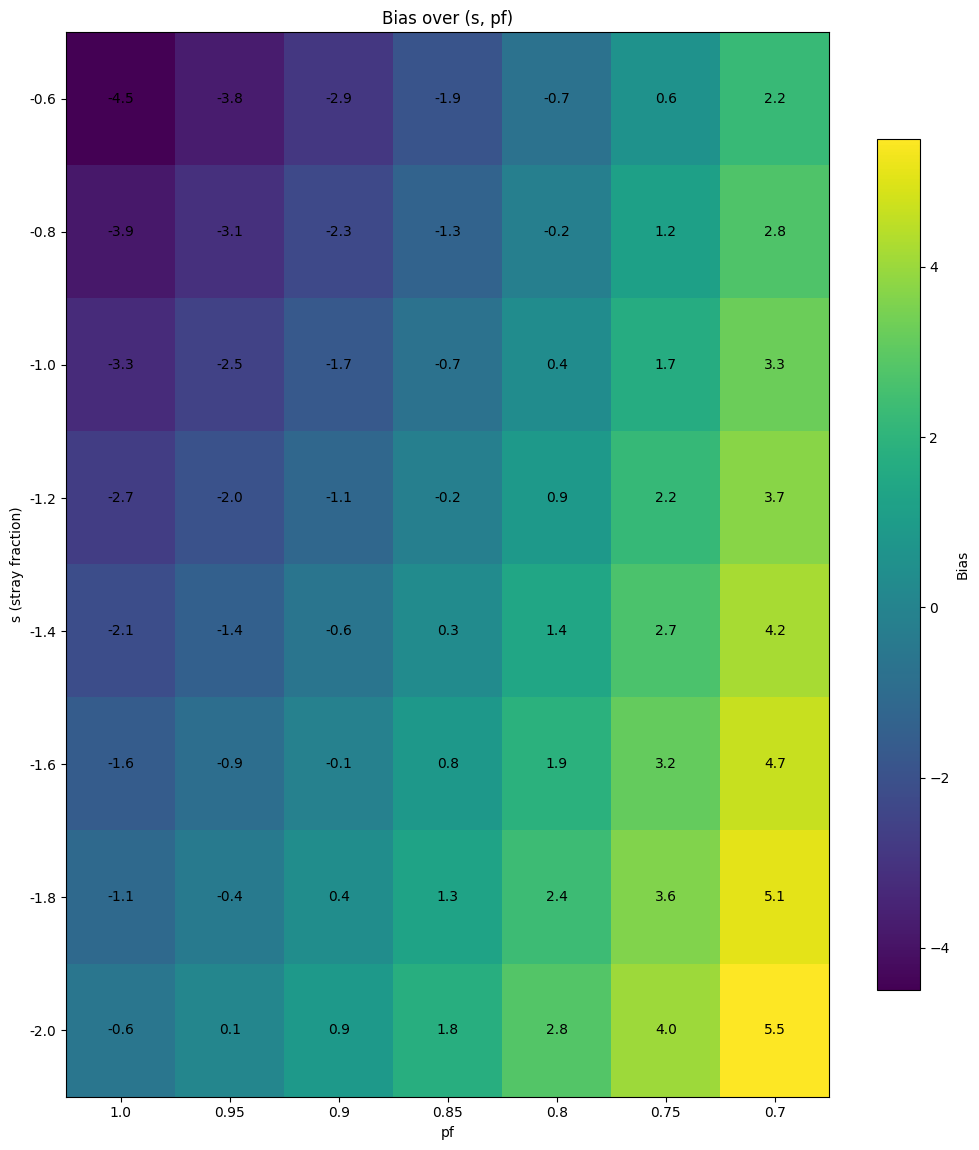

In [74]:
# ---- 1) Sweep all (s, pf) pairs and collect results ----
def run_grid(alldf, s_values, pf_values, save_path="wb_eval_grid.csv"):
    """
    For each (s, pf), calls:
       df_with_preds = wb_preds_for_df(alldf, s=s, pf=pf)
       eval_results  = eval_wb(df_with_preds)
    Returns a DataFrame with one row per (s, pf) containing top-level metrics.
    Also saves to CSV if save_path is not None.
    """
    rows = []
    for s, pf in product(s_values, pf_values):  # cartesian product
        dfp = wb_preds_for_df(alldf.copy(), s=s, pf=pf)  # use a copy just in case
        er  = eval_wb(dfp)

        # keep only top-level scalar metrics; stash the K-bin table as JSON (optional)
        byK = er.pop('by_K_bin', None)
        row = {'s': float(s), 'pf': float(pf)}
        row.update({k: (float(v) if np.isscalar(v) else v) for k, v in er.items()})
        if byK is not None:
            try:
                row['by_K_bin_json'] = json.dumps(byK.round(3).to_dict())
            except Exception:
                row['by_K_bin_json'] = None
        rows.append(row)

        print(f"s={s}, pf={pf} -> MAE={row['MAE']:.2f}, RMSE={row['RMSE']:.2f}, Bias={row['Bias']:.2f}, R2={row['R2']:.3f}")

    results = pd.DataFrame(rows)

    # normalize the column name for NRMSE if your eval returns 'NRMSE%_IQR'
    if 'NRMSE%_IQR' in results.columns:
        results = results.rename(columns={'NRMSE%_IQR': 'NRMSE_IQR_pct'})

    # optional: enforce the exact display order
    results['s']  = pd.Categorical(results['s'],  categories=s_values,  ordered=True)
    results['pf'] = pd.Categorical(results['pf'], categories=pf_values, ordered=True)

    if save_path:
        results.to_csv(save_path, index=False)
        print(f"\nSaved grid results to {save_path}")

    return results


# ---- 2) Plot a metric as an s×pf matrix (heatmap with value labels) ----
def plot_metric_grid(results_df, metric='RMSE', title=None, fmt="{:.2f}"):
    """
    Creates an s (rows) × pf (cols) matrix of the chosen metric and plots it.
    """
    if metric not in results_df.columns:
        raise KeyError(f"Metric '{metric}' not found in results_df columns: {list(results_df.columns)}")

    # ensure desired ordering (uses Categoricals if set above)
    df = results_df.copy()
    if not isinstance(df['s'].dtype, pd.CategoricalDtype):
        df = df.sort_values(['s', 'pf'])
    matrix = df.pivot(index='s', columns='pf', values=metric)

    fig, ax = plt.subplots(figsize=(1.2*matrix.shape[1]+2, 1.2*matrix.shape[0]+2))
    im = ax.imshow(matrix.values, aspect='auto')  # default colormap is fine

    # axes & labels
    ax.set_xticks(range(matrix.shape[1]), labels=[str(c) for c in matrix.columns])
    ax.set_yticks(range(matrix.shape[0]), labels=[str(r) for r in matrix.index])
    ax.set_xlabel("pf")
    ax.set_ylabel("s (stray fraction)")
    ax.set_title(title or f"{metric} over (s, pf)")

    # annotate cells
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix.values[i, j]
            if pd.notna(val):
                ax.text(j, i, fmt.format(val), ha='center', va='center')

    fig.colorbar(im, ax=ax, shrink=0.8, label=metric)
    plt.tight_layout()
    plt.show()


# ---- 3) Example usage ----
s_values = [-0.6, -0.8, -1, -1.2, -1.4, -1.6, -1.8, -2]
pf_values = [1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
results_df = run_grid(alldf, s_values, pf_values, save_path="wb_full_eval_grid.csv")
plot_metric_grid(results_df, metric="RMSE")        # heatmap of RMSE
plot_metric_grid(results_df, metric="MAE")         # or MAE, Bias, R2, NRMSE_IQR_pct, etc.
plot_metric_grid(results_df, metric="Bias", fmt="{:.1f}")        # heatmap of Bias

**Best Results** (the values were computed using hotspot - oil and no h. Best results for this case, not in general)

s = -1.4

Pf = 0.85


This makes no sense, because *s* should be positive. Also, when using these values, even though global values look good, bin values show that the model underpredicts for lower loads and overpredicts for big loads. This probably highlights a wrong value of the variables empirically measured.

In [75]:
print("Best results (lowest RMSE):")
best_results = results_df.loc[results_df['MAE'].idxmin()]
print(best_results)
print(best_results['by_K_bin_json'])

Best results (lowest RMSE):
s                                                             -1.4
pf                                                             0.9
MAE                                                       4.395323
RMSE                                                      5.800598
Bias                                                     -0.608246
NRMSE_IQR_pct                                            37.690692
R2                                                        0.776287
P95_abs_err                                              11.659373
Max_abs_err                                             111.152118
by_K_bin_json    {"n": {"<0.5": 183419.0, "0.5\u20130.9": 23173...
Name: 30, dtype: object
{"n": {"<0.5": 183419.0, "0.5\u20130.9": 23173.0, "0.9\u20131.1": 407.0, ">1.1": 0.0}, "MAE": {"<0.5": 4.257, "0.5\u20130.9": 5.497, "0.9\u20131.1": 3.974, ">1.1": NaN}, "RMSE": {"<0.5": 5.588, "0.5\u20130.9": 7.277, "0.9\u20131.1": 5.089, ">1.1": NaN}, "Bias": {"<0.5": -0.69, 

## Model Fit to Each Transformer

There are two main reasons to get the parameters again:

- Tuning just *s* and *PF* made the model lose physical meaning ($s < 0$).
- There is no reason to assume that the transformer rating values remained constant throughout the years.

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares

keys = ['s','pf','ambient_bias','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']
default_values = {
    's': 0.0,
    'pf': 1,
    'ambient_bias': 0.0,
}

# ---- WB model core (vectorized over a dataframe 'd') ----
def wb_predict(d, params):
    """
    d must have columns:
      ambient (°C), temp_meas (°C), P_kW (kW), rated_kVA (kVA),
      Pcu_ref_W (W at reference temp), P0_W (W at rated V)
    params: dict with keys ['s','pf','ambient_bias','deltaTopOil','deltaHotspot','x','y','h']
    Returns vector of predicted absolute HS temperature (°C).
    """
    s   = params['s']
    pf  = params['pf']
    amb = params['ambient_bias']
    dTO = params['heatRunTest_deltaTopOil']
    dH  = params['heatRunTest_deltaHotspot']
    x   = params['heatRunTest_x']
    y   = params['heatRunTest_y']
    h   = params['heatRunTest_h']

    # R and K
    Pload_ref = d['heatRunTest_copperLosses'] / (1.0 - s)  # W
    R = Pload_ref / d['heatRunTest_noLoadLosses']               # dimensionless
    K = (d['load'] / (pf * d['nominalLoad'] * 1000)) # per-unit (assumes P in kW, S_rated in MVA)

    # Clamp K to sane range to avoid exploding residuals during early iterations
    K = np.clip(K.values, 0, 2.5)

    # R may vary by timestamp if Pcu_ref_W or P0_W are columns; if they are scalars, broadcast works.
    R = np.asarray(R)

    top_oil_rise = dTO * np.power((1.0 + R * (K**2)) / (1.0 + R), x)
    hs_rise      = h * (K**y) * (dH - dTO)

    return d['temperature'].values + top_oil_rise + hs_rise #+ amb

# ---- residuals for robust least squares ----
def residuals_vec(theta, d, priors=None, prior_weight=0.0):
    # unpack vector -> params dict
    p = {
        's':            theta[0],
        'pf':           theta[1],
        'ambient_bias': theta[2],
        'heatRunTest_deltaTopOil':  theta[3],
        'heatRunTest_deltaHotspot': theta[4],
        'heatRunTest_x':            theta[5],
        'heatRunTest_y':            theta[6],
        'heatRunTest_h':            theta[7],
    }
    pred = wb_predict(d, p)
    res  = pred - d['hotspotTemperature'].values

    # optional light regularization toward priors to help identifiability (pf,s,x,y)
    if priors and prior_weight > 0:
        reg = []
        for k, mu in priors.items():
            reg.append(prior_weight * (p[k] - mu))
        res = np.concatenate([res, np.array(reg, dtype=float)])

    return res

# ---- get preds and metrics from model params ----
def get_preds_and_metrics(d, params_hat):

        # predictions & quick metrics
        pred = wb_predict(d, params_hat)
        err  = pred - d['hotspotTemperature'].values
        mae  = float(np.mean(np.abs(err)))
        rmse = float(np.sqrt(np.mean(err**2)))
        bias = float(np.mean(err))
        r2   = float(1 - np.sum(err**2) / np.sum((d['hotspotTemperature'] - d['hotspotTemperature'].mean())**2))
        return {'MAE': mae, 'RMSE': rmse, 'Bias': bias, 'R2': r2}, pred

# ---- fit one transformer (grouped df) ----
def fit_transformer(df_equipment,
                    init=None,
                    bounds=None,
                    priors=None,
                    prior_weight=0.0):
    # defaults
    if init is None:
        init = dict(
            s=0.10, pf=0.95, ambient_bias=0.0,
            heatRunTest_deltaTopOil=50.0, heatRunTest_deltaHotspot=63.0,  # rough starting rises (°C)
            heatRunTest_x=0.8, heatRunTest_y=1.5, heatRunTest_h=1.0
        )

    if bounds is None:
        bounds = dict(
            s=(0.0, 0.25),
            pf=(0.80, 1.00),
            ambient_bias=(-2.0, 2.0),
            heatRunTest_deltaTopOil=(5.0, 80.0),
            heatRunTest_deltaHotspot=(10.0, 120.0),
            heatRunTest_x=(0.6, 1.2),
            heatRunTest_y=(0.8, 2.2),
            heatRunTest_h=(0.7, 1.5),
        )

    # pack into vectors
    x0 = np.array([init[k] for k in ['s','pf','ambient_bias','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']], dtype=float)
    lb = np.array([bounds[k][0] for k in ['s','pf','ambient_bias','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']], dtype=float)
    ub = np.array([bounds[k][1] for k in ['s','pf','ambient_bias','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']], dtype=float)

    # drop NAs and obviously bad rows
    d = df_equipment[['temperature','hotspotTemperature','load','nominalLoad','heatRunTest_copperLosses','heatRunTest_noLoadLosses']].dropna().copy()
    # optional: restrict to a time window here if needed

    # robust least squares
    sol = least_squares(
        residuals_vec, x0,
        args=(d, priors, prior_weight),
        bounds=(lb, ub),
        loss='soft_l1', f_scale=5.0,  # robust to outliers
        max_nfev=200
    )

    keys = ['s','pf','ambient_bias','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']
    params_hat = {k: float(v) for k, v in zip(keys, sol.x)}
    metrics, pred = get_preds_and_metrics(d, params_hat)

    return params_hat, metrics, pred

# ---- batch fit across transformers ----
def fit_all_transformers(df,
                         id_col='equipmentId',
                         priors=None,
                         prior_weight=0.0, og_comparison=False):
    results = []
    preds   = []

    for eid, g in df.groupby(id_col):
        try:
            p_hat, metrics, pred = fit_transformer(g, priors=priors, prior_weight=prior_weight)
            row = {'equipmentId': eid, 'year': 2024, **p_hat, **metrics, 'n': int(len(g))}
            results.append(row)

            tmp = g[['dateTime', id_col, 'hotspotTemperature']].copy()
            tmp['wb_pred_fit'] = pred
            preds.append(tmp)
        except Exception as e:
            results.append({'equipmentId': eid, 'error': str(e)})

        if og_comparison:
            tfo_parameters = pd.read_csv(TFO_PARAMETERS_FILE)
            rename_map = {
                'deltaTopOil':     'heatRunTest_deltaTopOil',
                'deltaHotspot':    'heatRunTest_deltaHotspot',
                'x':               'heatRunTest_x',
                'y':               'heatRunTest_y',
                'h':               'heatRunTest_h',
                # Optional but useful elsewhere in your pipeline:
                'noLoadLosses':    'heatRunTest_noLoadLosses',
                'copperLosses':    'heatRunTest_copperLosses',
            }
            tfo_parameters.rename(columns=rename_map, inplace=True)
            if eid in tfo_parameters['equipmentId'].values:
                row = tfo_parameters[tfo_parameters['equipmentId'] == eid].iloc[0]
                og_params = {}
                for k in keys:
                    if k in row and pd.notna(row[k]):
                        og_params[k] = float(row[k])
                    elif k in default_values:
                        og_params[k] = default_values[k]
                    else:
                        raise KeyError(f"Missing parameter '{k}' for equipmentId={eid}")
                metrics, pred = get_preds_and_metrics(g, og_params)
                row = {'equipmentId': eid, 'year': g['manufactureYear'].values[0], **og_params, **metrics, 'n': int(len(g))}
                results.append(row)

    return pd.DataFrame(results), (pd.concat(preds, ignore_index=True) if preds else None)


In [128]:
# Your big dataframe needs these columns:
# timestamp, equipment_id, temp_meas (absolute HS temp), ambient (°C),
# P_kW (real power in kW), rated_kVA, Pcu_ref_W, P0_W

# Optional priors to stabilize fits (recommended)
# prior_weight = 0.2  # small pull toward priors

fit_table, pred_df = fit_all_transformers(alldf, id_col='equipmentId', og_comparison=True)

# Save results
fit_table.to_csv("wb_fit_parameters_by_transformer.csv", index=False)
if pred_df is not None:
    pred_df.to_csv("wb_predictions_fitted.csv", index=False)


In [108]:
eid = 5025312
tfo_parameters = pd.read_csv(TFO_PARAMETERS_FILE)
rename_map = {
    'deltaTopOil':     'heatRunTest_deltaTopOil',
    'deltaHotspot':    'heatRunTest_deltaHotspot',
    'x':               'heatRunTest_x',
    'y':               'heatRunTest_y',
    'h':               'heatRunTest_h',
    # Optional but useful elsewhere in your pipeline:
    'noLoadLosses':    'heatRunTest_noLoadLosses',
    'copperLosses':    'heatRunTest_copperLosses',
}
tfo_parameters.rename(columns=rename_map, inplace=True)
# desired_cols = ['equipmentId'] + keys
# tfo_parameters = tfo_parameters[desired_cols]
if eid in tfo_parameters['equipmentId'].values:
    og_params = tfo_parameters[tfo_parameters['equipmentId'] == eid].iloc[0].to_dict()
    metrics, pred = get_preds_and_metrics(df, og_params)

In [129]:
fit_table

,equipmentId,year,s,pf,ambient_bias,heatRunTest_deltaTopOil,heatRunTest_deltaHotspot,heatRunTest_x,heatRunTest_y,heatRunTest_h,MAE,RMSE,Bias,R2,n
0,24917,2024,5.036357e-07,1.000000,1.980000,74.295733,57.782521,0.600000,1.668296,1.123231,3.697070,4.726596,-0.126970,0.383362,14664
1,24917,1997,0.000000e+00,1.000000,0.000000,54.800000,72.000000,0.730000,1.400000,1.300000,4.737509,5.781923,-1.573298,0.077263,14664
2,33291,2024,3.771260e-09,1.000000,1.980000,79.999999,53.869058,0.637083,1.736099,1.186269,2.228510,2.788943,-0.045905,0.713541,14664
3,33291,1998,0.000000e+00,1.000000,0.000000,47.900000,65.400000,0.740000,1.430000,1.300000,6.079759,6.772061,-6.000365,-0.688981,14664
4,5004597,2024,9.975030e-02,0.921184,1.980000,60.539622,35.975918,0.600000,2.160808,1.264024,2.447127,3.688879,-0.326771,0.636929,14664
5,5004597,2001,0.000000e+00,1.000000,0.000000,48.900000,65.700000,0.620000,1.980000,1.300000,2.870896,4.253589,-1.876394,0.517259,14664
6,5004625,2024,2.500000e-01,0.800000,1.980000,65.850804,27.450293,0.600001,2.183562,1.463129,2.597965,3.904975,-0.246219,0.629797,14664
7,5004625,2001,0.000000e+00,1.000000,0.000000,48.900000,65.700000,0.620000,1.980000,1.300000,3.081849,4.448063,-1.927942,0.519663,14664
8,5017843,2024,6.460667e-07,1.000000,-1.980000,61.933554,64.264145,0.708594,0.800000,1.025598,1.710261,2.192043,-0.024277,0.873137,14664
9,5017843,2005,0.000000e+00,1.000000,0.000000,45.400000,60.800000,0.900000,1.600000,1.350000,5.351348,5.765622,-5.330528,0.122334,14664


In [130]:
def compute_differences(df):
    # sort to make sure earlier year comes first
    df_sorted = df.sort_values(['equipmentId','year'])
    
    diffs = []
    for eid, g in df_sorted.groupby('equipmentId'):
        if len(g) != 2:
            raise ValueError(f"Equipment {eid} does not have exactly 2 rows")
        
        # earlier and later rows
        g = g.reset_index(drop=True)
        row0 = g.iloc[0]
        row1 = g.iloc[1]
        
        diff = (row1 - row0).to_dict()  # subtract elementwise
        diff['equipmentId'] = eid
        diff['year_diff'] = row1['year'] - row0['year']
        
        diffs.append(diff)
    
    return pd.DataFrame(diffs)

# Example usage:
diff_df = compute_differences(fit_table)
diff_df

,equipmentId,year,s,pf,ambient_bias,heatRunTest_deltaTopOil,heatRunTest_deltaHotspot,heatRunTest_x,heatRunTest_y,heatRunTest_h,MAE,RMSE,Bias,R2,n,year_diff
0,24917,27.0,5.036357e-07,-1.631906e-11,1.980000,19.495733,-14.217479,-0.130000,0.268296,-0.176769,-1.040439,-1.055326,1.446329,0.306099,0.0,27.0
1,33291,26.0,3.771260e-09,-8.680119e-08,1.980000,32.099999,-11.530942,-0.102917,0.306099,-0.113731,-3.851249,-3.983118,5.954460,1.402522,0.0,26.0
2,5004597,23.0,9.975030e-02,-7.881572e-02,1.980000,11.639622,-29.724082,-0.020000,0.180808,-0.035976,-0.423769,-0.564710,1.549622,0.119670,0.0,23.0
3,5004625,23.0,2.500000e-01,-2.000000e-01,1.980000,16.950804,-38.249707,-0.019999,0.203562,0.163129,-0.483884,-0.543088,1.681724,0.110133,0.0,23.0
4,5017843,19.0,6.460667e-07,-6.029346e-08,-1.980000,16.533554,3.464145,-0.191406,-0.800000,-0.324402,-3.641087,-3.573579,5.306252,0.750803,0.0,19.0
5,5017873,20.0,2.762243e-04,-6.544964e-02,1.980000,6.386915,-20.122829,-0.299984,0.599986,-0.205443,-3.608724,-3.582856,5.621282,1.236475,0.0,20.0
6,5025312,17.0,2.770898e-11,-4.447553e-13,-1.980000,28.099998,-15.683948,-0.060000,0.068264,0.134332,-2.787014,-3.077063,4.746337,0.807501,0.0,17.0
7,5026188,18.0,1.577981e-06,-1.169251e-08,1.980000,24.647360,-24.498351,-0.189999,0.753202,-0.043342,-4.032381,-4.147071,6.032175,1.668403,0.0,18.0
8,5027447,17.0,3.244209e-09,-1.767123e-01,-1.980000,33.299999,-21.456583,-0.300000,0.476437,0.242996,-8.905851,-7.866067,12.014364,2.829291,0.0,17.0
9,5030256,17.0,6.529112e-10,-2.109424e-14,-1.980000,-42.114499,4.137477,-0.060000,-0.540000,-0.017019,-6.959880,-7.090849,11.259377,3.187901,0.0,17.0


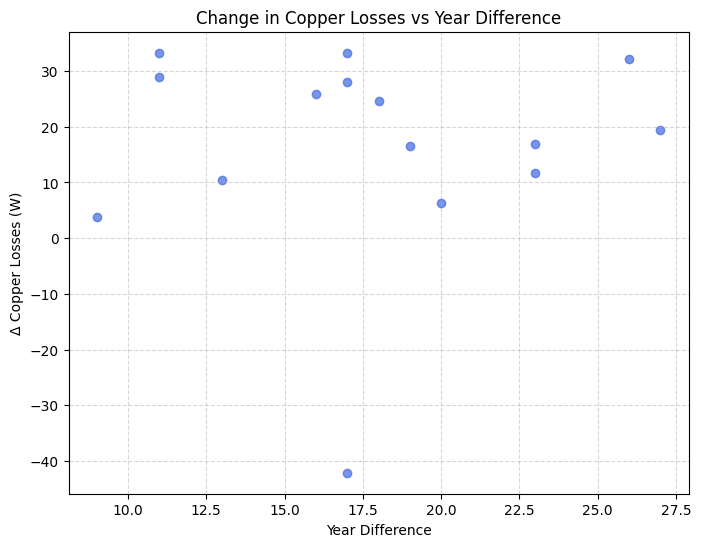

In [132]:
plt.figure(figsize=(8,6))
plt.scatter(diff_df['year_diff'], diff_df['heatRunTest_deltaTopOil'], color='royalblue', alpha=0.7)

plt.xlabel("Year Difference")
plt.ylabel("Δ Copper Losses (W)")
plt.title("Change in Copper Losses vs Year Difference")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

FROM HERE ITS ALL CHATGPT. I NEED TO CHECK IT!

In [ ]:
# ---- master registry for all parameters you might fit ----
PARAMS_REGISTRY = {
    # thermal shape/scale params
    's':                          {'default': 0.10, 'bounds': (0.0, 0.25)},
    'pf':                         {'default': 0.95, 'bounds': (0.80, 1.00)},
    'ambient_bias':               {'default': 0.0,  'bounds': (-2.0, 2.0)},

    'heatRunTest_deltaTopOil':    {'default': 50.0, 'bounds': (5.0, 80.0)},
    'heatRunTest_deltaHotspot':   {'default': 63.0, 'bounds': (10.0, 120.0)},
    'heatRunTest_x':              {'default': 0.8,  'bounds': (0.6, 1.2)},
    'heatRunTest_y':              {'default': 1.5,  'bounds': (0.8, 2.2)},
    'heatRunTest_h':              {'default': 1.0,  'bounds': (0.7, 1.5)},

    # equipment constants (OPTIONALLY fit as scalars overriding df columns)
    'heatRunTest_copperLosses':   {'default': None, 'bounds': (10.0, 1e6)},  # W
    'heatRunTest_noLoadLosses':   {'default': None, 'bounds': (10.0, 1e6)},  # W
    'nominalLoad':                {'default': None, 'bounds': (1.0, 1e6)},   # kVA
}

# ---- choose what you want to fit today (just edit this list) ----
# original set:
# selected_keys = ['s','pf','ambient_bias','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']

# example including copper/no-load losses and nominalLoad as fitted scalars:
selected_keys = [
    's','pf','ambient_bias',
    'heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h',
    'heatRunTest_copperLosses','heatRunTest_noLoadLosses','nominalLoad'
]


In [ ]:
def build_x0_bounds(selected_keys, init_overrides=None, bounds_overrides=None):
    x0, lb, ub = [], [], []
    for k in selected_keys:
        dflt  = PARAMS_REGISTRY[k]['default']
        b_l, b_u = PARAMS_REGISTRY[k]['bounds']
        if init_overrides and k in init_overrides:
            dflt = init_overrides[k]
        if bounds_overrides and k in bounds_overrides:
            b_l, b_u = bounds_overrides[k]
        if dflt is None:
            # if no default, try infer from df later; for now seed mid of bounds
            dflt = (b_l + b_u) / 2.0
        x0.append(float(dflt)); lb.append(float(b_l)); ub.append(float(b_u))
    return np.array(x0), np.array(lb), np.array(ub)

def vec_to_params(theta, selected_keys):
    return {k: float(v) for k, v in zip(selected_keys, theta)}


In [ ]:
def _get_series_or_param(d, params, param_key, df_col):
    """If param_key was selected & fitted, use that scalar (broadcast).
       Else fallback to the dataframe column."""
    if param_key in params:
        return np.full(len(d), float(params[param_key]), dtype=float)
    return d[df_col].to_numpy(dtype=float)

def wb_predict(d, params):
    s   = params.get('s',  PARAMS_REGISTRY['s']['default'])
    pf  = params.get('pf', PARAMS_REGISTRY['pf']['default'])

    dTO = params.get('heatRunTest_deltaTopOil',  PARAMS_REGISTRY['heatRunTest_deltaTopOil']['default'])
    dH  = params.get('heatRunTest_deltaHotspot', PARAMS_REGISTRY['heatRunTest_deltaHotspot']['default'])
    x   = params.get('heatRunTest_x',            PARAMS_REGISTRY['heatRunTest_x']['default'])
    y   = params.get('heatRunTest_y',            PARAMS_REGISTRY['heatRunTest_y']['default'])
    h   = params.get('heatRunTest_h',            PARAMS_REGISTRY['heatRunTest_h']['default'])

    # equipment scalars (may be fitted or from df)
    Pcu_ref_W = _get_series_or_param(d, params, 'heatRunTest_copperLosses', 'heatRunTest_copperLosses')
    P0_W      = _get_series_or_param(d, params, 'heatRunTest_noLoadLosses', 'heatRunTest_noLoadLosses')
    S_kVA     = _get_series_or_param(d, params, 'nominalLoad',              'nominalLoad')

    # R and K
    Pload_ref = Pcu_ref_W / (1.0 - s)
    R = Pload_ref / P0_W

    # If you have 'load' in kW:
    P_kW = d['load'].to_numpy(dtype=float)
    K = P_kW / (pf * S_kVA)  # per-unit (assuming nameplate in kVA)
    K = np.clip(K, 0.0, 2.5)

    # rises
    top_oil_rise = dTO * np.power((1.0 + R * (K**2)) / (1.0 + R), x)
    hs_rise      = h * (K**y) * (dH - dTO)

    ambient = d['temperature'].to_numpy(dtype=float)
    amb_bias = params.get('ambient_bias', 0.0)
    return ambient + amb_bias + top_oil_rise + hs_rise


In [ ]:
def residuals_vec(theta, d, selected_keys, priors=None, prior_weight=0.0):
    params = vec_to_params(theta, selected_keys)
    pred = wb_predict(d, params)
    res  = pred - d['hotspotTemperature'].to_numpy(dtype=float)

    if priors and prior_weight > 0:
        reg = []
        for k, mu in priors.items():
            if k in params:
                reg.append(prior_weight * (params[k] - mu))
        if reg:
            res = np.concatenate([res, np.array(reg, dtype=float)], axis=0)
    return res


In [ ]:
def get_preds_and_metrics(d, params_hat):
    pred = wb_predict(d, params_hat)
    tgt  = d['hotspotTemperature'].to_numpy(dtype=float)
    err  = pred - tgt
    mae  = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err**2)))
    bias = float(np.mean(err))
    denom = np.sum((tgt - tgt.mean())**2)
    r2   = float(1 - np.sum(err**2) / denom) if denom > 0 else np.nan
    return {'MAE': mae, 'RMSE': rmse, 'Bias': bias, 'R2': r2}, pred

def fit_transformer(df_equipment,
                    selected_keys,
                    init_overrides=None,
                    bounds_overrides=None,
                    priors=None,
                    prior_weight=0.0):

    # core columns we always need in df (even if some are fitted, we still allow fallback)
    needed = ['temperature','hotspotTemperature','load','nominalLoad',
              'heatRunTest_copperLosses','heatRunTest_noLoadLosses']
    have = [c for c in needed if c in df_equipment.columns]
    if len(have) < len(needed):
        missing = [c for c in needed if c not in df_equipment.columns]
        raise KeyError(f"Missing columns: {missing}")

    d = df_equipment[needed].dropna().copy()
    if d.empty:
        raise ValueError("No valid rows after dropna for this transformer.")

    x0, lb, ub = build_x0_bounds(selected_keys, init_overrides, bounds_overrides)

    sol = least_squares(
        residuals_vec, x0,
        args=(d, selected_keys, priors, prior_weight),
        bounds=(lb, ub),
        loss='soft_l1', f_scale=5.0, max_nfev=500
    )
    params_hat = vec_to_params(sol.x, selected_keys)
    metrics, pred = get_preds_and_metrics(d, params_hat)
    return params_hat, metrics, pred

def fit_all_transformers(df, id_col='equipmentId', selected_keys=None,
                         init_overrides=None, bounds_overrides=None,
                         priors=None, prior_weight=0.0, og_comparison=False):
    if selected_keys is None:
        selected_keys = ['s','pf','ambient_bias','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']

    results, preds = [], []
    for eid, g in df.groupby(id_col):
        try:
            p_hat, metrics, pred = fit_transformer(
                g, selected_keys,
                init_overrides=init_overrides,
                bounds_overrides=bounds_overrides,
                priors=priors, prior_weight=prior_weight
            )
            row = {'equipmentId': eid, **p_hat, **metrics, 'n': int(len(g))}
            results.append(row)

            tmp = g[['dateTime', id_col, 'hotspotTemperature']].copy()
            tmp['wb_pred_fit'] = pred
            preds.append(tmp)
        except Exception as e:
            results.append({'equipmentId': eid, 'error': str(e)})

        # (optional) compare against OG params file if you want — you can reuse your previous block,
        # just build the dict with only the keys you care about:
        # if og_comparison: ...
    res_df = pd.DataFrame(results)
    pred_df = pd.concat(preds, ignore_index=True) if preds else None
    return res_df, pred_df


In [ ]:
selected_keys = [
    's','pf','ambient_bias',
    'heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h',
    'heatRunTest_copperLosses','heatRunTest_noLoadLosses','nominalLoad'
]

# (optional) Seed initial guesses from your CSV if present
init_overrides = {}
# e.g., if you have per-equipment constants you want to seed, you can pass different init_overrides per equipment.

fit_table, pred_df = fit_all_transformers(
    alldf, id_col='equipmentId',
    selected_keys=selected_keys,
    init_overrides=init_overrides,
    prior_weight=0.1
)


| Parameter                                | Physical meaning                            | Possible time-dependent effect                                          | Likely trend with age          |
| ---------------------------------------- | ------------------------------------------- | ----------------------------------------------------------------------- | ------------------------------ |
| **s** (stray-loss fraction)              | Fraction of load losses in structural parts | Winding displacement, mechanical loosening → altered leakage flux paths | ↑ (slight increase)            |
| **pf** (effective load power factor)     | Typical operating load PF                   | Customer mix changes (industrial → residential, renewables, EVs)        | Variable (↑ or ↓)              |
| **ambient\_bias**                        | Sensor/systematic offset                    | Sensor drift, probe replacement, fouling causing localized heating      | Unpredictable (±), often drift |
| **ΔTopOil (heatRunTest\_deltaTopOil)**   | Oil rise at rated load                      | Oil oxidation, sludge formation, fan/pump wear                          | ↑ (higher rises)               |
| **ΔHotspot (heatRunTest\_deltaHotspot)** | Hotspot rise at rated load                  | Insulation embrittlement, reduced heat transfer to oil                  | ↑ (higher rises)               |
| **x** (oil exponent)                     | Nonlinearity of oil heating curve           | Oil viscosity increase, convection impairment                           | ↑ (slightly higher)            |
| **y** (winding exponent)                 | Nonlinearity of winding heating curve       | Blocked ducts, uneven cooling, sludge                                   | ↑ (slightly higher)            |
| **h** (hotspot factor)                   | Ratio hotspot/top-oil                       | Localized hot-spots worsen as insulation/cooling paths degrade          | ↑                              |
| **Copper losses (Pcu\_ref\_W)**          | I²R losses in windings                      | Conductor oxidation, joints resistance increase, deformation            | ↑                              |
| **No-load losses (P0\_W)**               | Core losses at rated voltage                | Lamination insulation breakdown → higher eddy currents                  | ↑ (rare, but serious)          |
| **Nominal load (S\_rated)**              | Rated kVA capacity                          | Effective derating in practice due to aging cooling/insulation          | ↓ (derated capacity)           |
